In [38]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import glob
import os
import warnings
from datetime import datetime, timedelta
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
from copy import deepcopy
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error


from lstm import ShallowRegressionLSTM


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


In [39]:
# load dataset and show the first run
case1run1 = pd.read_csv('./mill_data/case1run1.csv')
case1run2 = pd.read_csv('./mill_data/case1run2.csv')
columns=['case', 'run', 'VB', 'time', 'doc','feed','material','smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle']
case1run1.columns = columns
case1run2.columns = columns

In [44]:
def sliding_windows(data, seq_length):
    x = []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        x.append(_x)

    return np.array(x)

In [45]:
def labeling(data,seq_length,lab):
    x = []
    for i in range(len(data)-seq_length-1):
        x.append(lab)

    return np.array(x)

In [47]:
path = './mill_data/'
file_list = os.listdir(path)

In [51]:
def to_dataset(data,label):
    smcAC=np.expand_dims(sliding_windows(data['smcAC'][3000:-3000],4),axis=2)
    smcDC=np.expand_dims(sliding_windows(data['smcDC'][3000:-3000],4),axis=2)
    vib_table=np.expand_dims(sliding_windows(data['vib_table'][3000:-3000],4),axis=2)
    vib_spindle=np.expand_dims(sliding_windows(data['vib_spindle'][3000:-3000],4),axis=2)
    AE_table=np.expand_dims(sliding_windows(data['AE_table'][3000:-3000],4),axis=2)
    AE_spindle=np.expand_dims(sliding_windows(data['AE_spindle'][3000:-3000],4),axis=2)
    xdata = np.concatenate((smcAC,smcDC,vib_table,vib_spindle,AE_table,AE_spindle),axis=2)
    ydata = labeling(data[3000:-3000],4, label)
    return xdata,ydata

In [52]:
def to_casedataset(data_list):
    empty_x=np.zeros(((1, 4, 6)))
    empty_y=np.zeros(((1)))

    for i in data_list:
        pdd=pd.read_csv('./mill_data/'+i)
        pdd.columns = columns
        lab=pdd['VB'][0]
        if str(lab)!='nan':
            x_,y_=to_dataset(pdd,lab)
            empty_x=np.concatenate((empty_x,x_),axis=0)
            empty_y=np.concatenate((empty_y,y_),axis=0)
    
    return empty_x[1:],empty_y[1:]

In [53]:
case1list=[file for file in file_list if file.startswith('case1run')]
case9list=[file for file in file_list if file.startswith('case9run')]

In [54]:
c1_x,c1_y=to_casedataset(case1list)

In [55]:
c9_x,c9_y=to_casedataset(case9list)

In [59]:
class SequenceDataset(Dataset):
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i): 
        data=self.x[i]
        label=self.y[i]

        return data,label

In [60]:
c1_x = Variable(torch.Tensor(np.array(c1_x)))
c1_y = Variable(torch.Tensor(np.array(c1_y)))
c9_x = Variable(torch.Tensor(np.array(c9_x)))
c9_y = Variable(torch.Tensor(np.array(c9_y)))


print("train shape is:",c1_x.size())
print("train label shape is:",c1_y.size())
print("test shape is:",c9_x.size())
print("test label shape is:",c9_y.size())

train shape is: torch.Size([64922, 4, 6])
train label shape is: torch.Size([64922])
test shape is: torch.Size([44946, 4, 6])
test label shape is: torch.Size([44946])


In [61]:
c1_dataset=SequenceDataset(c1_x,c1_y)
c9_dataset=SequenceDataset(c9_x,c9_y)

In [62]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

train_loader = DataLoader(c1_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(c9_dataset, batch_size=1, shuffle=False)


In [65]:
learning_rate = 5e-5
num_hidden_units = 4
epochs = 50
model = ShallowRegressionLSTM(num_sensors=6, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [66]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = torch.sqrt(loss_function(output, y))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += torch.sqrt(loss_function(output, y)).item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [67]:

print("Untrained test")
print(test_model(test_loader, model, loss_function))
best_fitness = -100000


Untrained test
0.6749578940000022


run: 0
train_loss: 0.3610555927937932
test_loss: 0.2112879937532317
run: 1
train_loss: 0.13552657062047335
test_loss: 0.15579049356428626
run: 2
train_loss: 0.08837151997426626
test_loss: 0.14603846178041602
run: 3
train_loss: 0.07582531625587638
test_loss: 0.13334254347590574
run: 4
train_loss: 0.06986344028622309
test_loss: 0.1260065471477724
run: 5
train_loss: 0.0659369989135337
test_loss: 0.11998226099849776
run: 6
train_loss: 0.06272465065158371
test_loss: 0.1137428207947318
run: 7
train_loss: 0.059960107029424385
test_loss: 0.1099263052736435
run: 8
train_loss: 0.05759449487119663
test_loss: 0.10692308457544335
run: 9
train_loss: 0.05560368019857978
test_loss: 0.10367802700902827
run: 10
train_loss: 0.05396932578875609
test_loss: 0.1017889063295607
run: 11
train_loss: 0.05262272582816749
test_loss: 0.10059991068861218
run: 12
train_loss: 0.05157630789810181
test_loss: 0.09975149813476357
run: 13
train_loss: 0.05074136501325945
test_loss: 0.09914286773230292
run: 14
train_loss: 0.

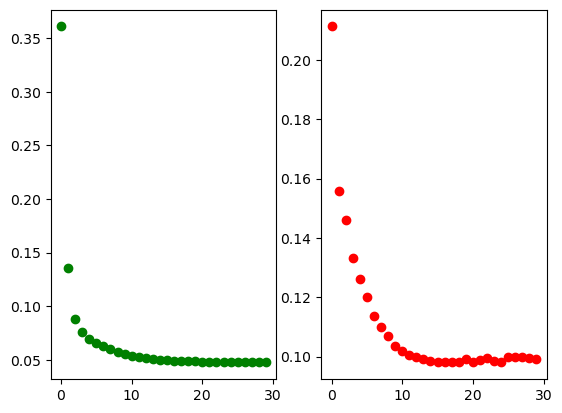

In [68]:
fig, axs = plt.subplots(1, 2)
for epoch in range(30):
    print("run:", epoch)
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print("train_loss:",train_loss)
    print("test_loss:",test_loss)
    axs[0].scatter(epoch, train_loss, color='g')
    axs[1].scatter(epoch, test_loss, color='r')
    fitness = -test_loss
    if fitness > best_fitness:
        best_fitness = fitness
        best_model = deepcopy(model)

In [69]:
axs[0].set_yscale('log')
axs[1].set_yscale('log')
plt.show()
plt.cla()
plt.clf()
plt.close()

In [75]:
def test_model2(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    a=[]
    b=[]
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += torch.sqrt(loss_function(output, y)).item()
            a.append(y)
            b.append(output)

    avg_loss = total_loss / num_batches
    return avg_loss,a,b

In [92]:
test_loader = DataLoader(c9_dataset, batch_size=4994, shuffle=False)
print('Predictions on test set')

Predictions on test set


In [93]:
c,v,n=test_model2(test_loader, model, loss_function)

In [94]:
q,w=[],[]
for i in range(len(v)):
    q.append(sum(v[i])/len(v[i]))
    w.append(sum(n[i])/len(n[i]))

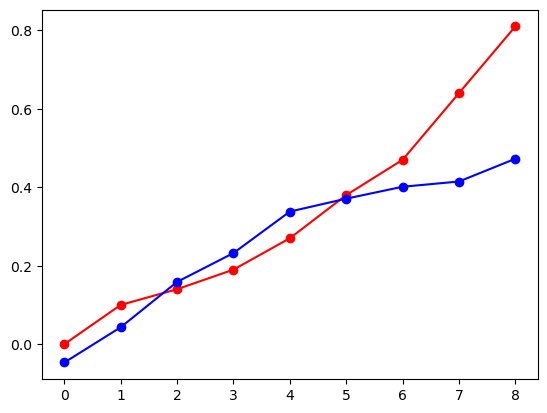

In [104]:
plt.plot(q, 'bo-',color='r')
plt.plot(w, 'bo-',color='b')

In [107]:
train_loader = DataLoader(c1_dataset, batch_size=int(len(c1_dataset)/13), shuffle=False)
print('Predictions on train set')

Predictions on train set


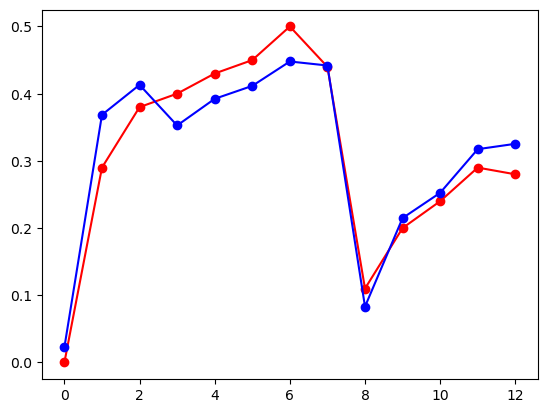

In [109]:
c,v,n=test_model2(train_loader, model, loss_function)
q,w=[],[]
for i in range(len(v)):
    q.append(sum(v[i])/len(v[i]))
    w.append(sum(n[i])/len(n[i]))
    
plt.plot(q, 'bo-',color='r')
plt.plot(w, 'bo-',color='b')